In [2]:
!pip install netcdf4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.6 MB/s eta 0:00:00


**This code follows the method proposed by Kern et al. 2022 (DOI: 10.5194/tc-16-349-2022) for estimating sea ice concentration. This script adapts the method for use with VIIRS data, selecting similar bands:**

Following the relationship for albedo, and using top of atmosphere (toa) reflectance:

α_toa = a + b(α_surface)

a_1, b_1, a_2, and b_2 refer to the coffecients for channels 1 and 2.

In [3]:
# Import statements
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from netCDF4 import Dataset
from matplotlib.colors import ListedColormap, BoundaryNorm

In [4]:
# Coefficients applied in Kern et al. 2022
theta_0 = [0,10,20,30,40,50,60,70,75,80]
a_1  = [0.027,0.028,0.03,0.033,0.037,0.044,0.059,0.086,0.106,0.129]
b_1 = [0.895,0.894,0.892,0.887,0.879,0.867,0.839,0.791,0.755,0.713]
a_2 = [0.009,0.009,0.01,0.011,0.012,0.015,0.022,0.035,0.044,0.054]
b_2 = [0.858,0.857,0.856,0.854,0.85,0.843,0.83,0.804,0.783,0.757]

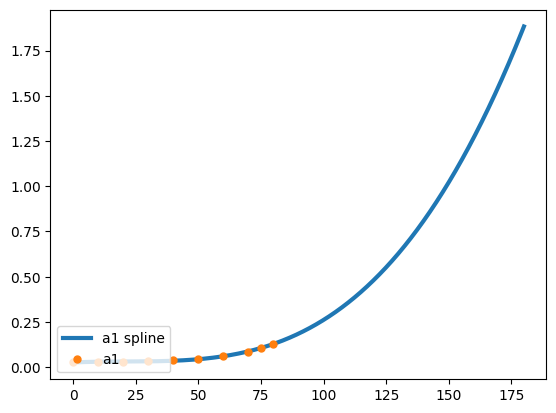

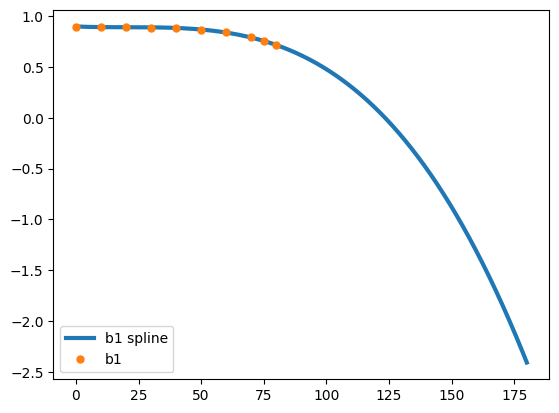

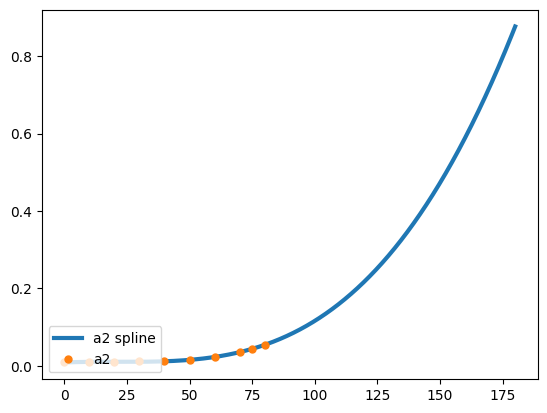

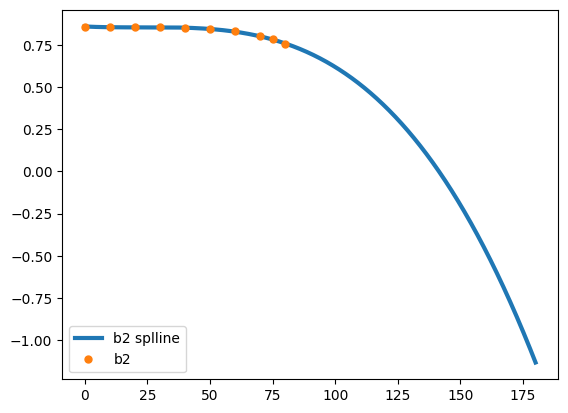

In [5]:
# Define that model the coefficients used by Kern et al. 2022
spl_a1 = UnivariateSpline(theta_0, a_1)
spl_b1 = UnivariateSpline(theta_0, b_1)
spl_a2 = UnivariateSpline(theta_0, a_2)
spl_b2 = UnivariateSpline(theta_0, b_2)

# Verify results by plotting
xs = np.round(np.arange(0, 180.001, 0.001,dtype=np.float32),3)

plt.plot(xs, spl_a1(xs), lw=3,label='a1 spline')
plt.plot(theta_0, a_1, 'o', ms=5,label='a1')
plt.legend(loc='lower left')
plt.show()

plt.plot(xs, spl_b1(xs), lw=3,label='b1 spline')
plt.plot(theta_0, b_1, 'o', ms=5,label='b1')
plt.legend(loc='lower left')
plt.show()

plt.plot(xs, spl_a2(xs), lw=3,label='a2 spline')
plt.plot(theta_0, a_2, 'o', ms=5,label='a2')
plt.legend(loc='lower left')
plt.show()

plt.plot(xs, spl_b2(xs), lw=3,label='b2 splline')
plt.plot(theta_0, b_2, 'o', ms=5,label='b2')
plt.legend(loc='lower left')
plt.show()

In [ ]:
# Splines
spline_a1 = spl_a1(xs)
spline_b1 = spl_b1(xs)
spline_a2 = spl_a2(xs)
spline_b2 = spl_b2(xs)

In [ ]:
# Navigation/geolocation data
filepath = '/content/drive/MyDrive/VNPMOD/'
filename_nav = 'VNP03MOD.A2018122.1236.002.2021081221406.nc'
nav_data = Dataset(filepath + filename_nav)
nav_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: VIIRS M-band Geolocation Data
    platform: Suomi-NPP
    instrument: VIIRS
    product_name: VNP03MOD.A2018122.1236.002.2021081221406.nc
    LocalGranuleID: VNP03MOD.A2018122.1236.002.2021081221406.nc
    LongName: VIIRS/NPP Moderate Resolution Terrain Corrected Geolocation 6-Min L1 Swath 750m
    ShortName: VNP03MOD
    date_created: 2021-03-22T18:19:33Z
    ProductionTime: 2021-03-22T18:19:33Z
    processing_version: v3.0.0
    Conventions: CF-1.6
    institution: NASA Goddard Space Flight Center, VIIRS L1 Processing Group
    license: http://science.nasa.gov/earth-science/earth-science-data/data-information-policy/
    naming_authority: gov.nasa.gsfc.VIIRSland
    keywords_vocabulary: NASA Global Change Master Directory (GCMD) Science Keywords
    standard_name_vocabulary: 
    creator_name: VIIRS L1 Processing Group
    creator_email: modis-ops@lists.nasa.gov
    creator_url: http://la

In [ ]:
# Calibrated radiance/reflectance band data
filename = 'VNP02MOD.A2018122.1236.002.2021081231243.nc'
band_data = Dataset(filepath + filename)
band_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    date_created: 2021-03-22T19:13:29Z
    ProductionTime: 2021-03-22T19:13:29Z
    title: VIIRS M-band Reflected Solar Band and Thermal Emissive Band Data
    ShortName: VNP02MOD
    LongName: VIIRS/NPP Moderate Resolution 6-Min L1B Swath 750m
    instrument: VIIRS
    processing_version: v3.0.0
    Conventions: CF-1.6
    institution: NASA Goddard Space Flight Center, VIIRS L1 Processing Group
    license: http://science.nasa.gov/earth-science/earth-science-data/data-information-policy/
    naming_authority: gov.nasa.gsfc.VIIRSland
    keywords_vocabulary: NASA Global Change Master Directory (GCMD) Science Keywords
    standard_name_vocabulary: 
    creator_name: VIIRS L1 Processing Group
    creator_email: modis-ops@lists.nasa.gov
    creator_url: http://ladsweb.nascom.nasa.gov
    project: VIIRS L1 Project
    publisher_name: LAADS
    publisher_url: http://ladsweb.nascom.nasa.gov
    publisher_em

In [ ]:
# Retrieve and format the solar zenith angles
theta_s = np.array(nav_data.groups['geolocation_data'].variables['solar_zenith'])
x,y = theta_s.shape
print('Solar Zenith Shape: ', theta_s.shape) # test
theta_s = np.absolute(90 - theta_s).astype(np.float32)
theta_s = np.round(theta_s,decimals=3)
print(np.unique(np.around(theta_s,decimals=3))) # formatted solar zenith data

Solar Zenith Shape:  (3232, 3200)
[ 3.71  3.72  3.73 ... 32.48 32.49 32.5 ]


In [ ]:
def retreive_coeffs(spline_a,spline_b,zeniths,spline_indices,x,y):
  a = np.zeros((x*y,))
  b = np.zeros((x*y,))
  for i in range(0,len(zeniths)):
    index = np.where(spline_indices == zeniths[i])
    a[i] = spline_a[index[0][0]]
    b[i] = spline_b[index[0][0]]
  a = a.reshape(x,y)
  b = b.reshape(x,y)
  return a,b

# Retreive the coeffs at each pixel in the scene, corresponding to the shape of the solar zenith data
a1,b1 = retreive_coeffs(spline_a1,spline_b1,theta_s.flatten(),xs, x,y)

In [ ]:
# Repeat for the second set of coefficients
a2,b2 = retreive_coeffs(spline_a2,spline_b2,theta_s.flatten(),xs, x,y)

In [ ]:
# Save the coefficients for re-use
a1_temp = a1
b1_temp = b1
a2_temp = a2
b2_temp = b2

coeffs_filename = filepath + filename + '_COEFFICIENTS.nc'

coeffs = xr.Dataset(
  data_vars=dict(
  a1=(["x","y"], a1),
  b1=(["x","y"], b1),
  a2=(["x","y"], a2),
  b2=(["x","y"], b2),
  ),
  attrs=dict(description="Spline coefficients corresponding to " + filename),
  )

coeffs.to_netcdf(path= coeffs_filename)


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: Spline coefficients corresponding to VNP02MOD.A2018122.1236.002.2021081231243.nc
    dimensions(sizes): x(3232), y(3200)
    variables(dimensions): float64 a1(x, y), float64 b1(x, y), float64 a2(x, y), float64 b2(x, y)
    groups: 

In [ ]:
# Test data file and assign the coefficients to variables
coeff_data = Dataset(coeffs_filename)
print(coeff_data)

a1_coeffs = np.array(coeff_data.variables['a1'])
b1_coeffs = np.array(coeff_data.variables['b1'])
a2_coeffs = np.array(coeff_data.variables['a2'])
b2_coeffs = np.array(coeff_data.variables['b2'])

a1 = a1_coeffs
b1 = b1_coeffs
a2 = a2_coeffs
b2 = b2_coeffs

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: Spline coefficients corresponding to VNP02MOD.A2018122.1236.002.2021081231243.nc
    dimensions(sizes): x(3232), y(3200)
    variables(dimensions): float64 a1(x, y), float64 b1(x, y), float64 a2(x, y), float64 b2(x, y)
    groups: 

In [ ]:
# Band scaling and radiance/reflectance scaling factors from VIIRS documentation
M04_scale = 1.9991758E-5
M05_scale = 1.9991758E-5
M07_scale = 1.9991758E-5
M04_rad_scale = 0.012003864
M05_rad_scale = 0.0098244045
M07_rad_scale = 0.0061797476

# Assign band data to variables and inspect
M04 = np.array(band_data.groups['observation_data'].variables['M04'])
M05 = np.array(band_data.groups['observation_data'].variables['M05'])
M07 = np.array(band_data.groups['observation_data'].variables['M07'])
print(np.unique(M04))
print(M04.shape)
print(np.unique(M05))
print(np.unique(M07))

[2.8628197e-02 2.8648188e-02 2.8708164e-02 ... 5.8871728e-01 5.8979684e-01
 6.5533000e+04]
(3232, 3200)
[1.6033391e-02 1.6073374e-02 1.6093364e-02 ... 6.4513403e-01 6.4757299e-01
 6.5533000e+04]
[7.876753e-03 7.896745e-03 7.936728e-03 ... 6.891159e-01 6.898756e-01
 6.553300e+04]


In [ ]:
# set pixels containing fill values (-999.9) to nan
fill = 65527 #valid range 0-65527 # extra: flag values are 65532, 65533, 65534
def set_fill(data, fill):
  fill_indices = np.where(data >= fill)
  np.put(data, fill_indices, np.nan)
  return data

In [ ]:
# Remove fill values
M04_flagged = set_fill(M04.flatten(),fill).reshape(x,y)
M05_flagged = set_fill(M05.flatten(),fill).reshape(x,y)
M07_flagged = set_fill(M07.flatten(),fill).reshape(x,y)

# Inspect
print(np.unique(M04_flagged))
print(np.unique(M05_flagged))
print(np.unique(M07_flagged))

[0.0286282  0.02864819 0.02870816 ... 0.5887173  0.58979684        nan]
[0.01603339 0.01607337 0.01609336 ... 0.64513403 0.647573          nan]
[0.00787675 0.00789674 0.00793673 ... 0.6891159  0.6898756         nan]


In [ ]:
# Surface albedo calculation
def calculate_surface_albedo(a_TOA, a, b):
  a_surf = (a_TOA - a)/b
  return a_surf

In [ ]:
# Band reflectance data
M04_reflectance = (M04_flagged)/(np.cos(np.radians(theta_s)))
print(np.unique(np.around(M04_reflectance,decimals=1))) # inspect

M05_reflectance = (M05_flagged)/(np.cos(np.radians(theta_s)))
M07_reflectance = (M07_flagged)/(np.cos(np.radians(theta_s)))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 nan]


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 nan]


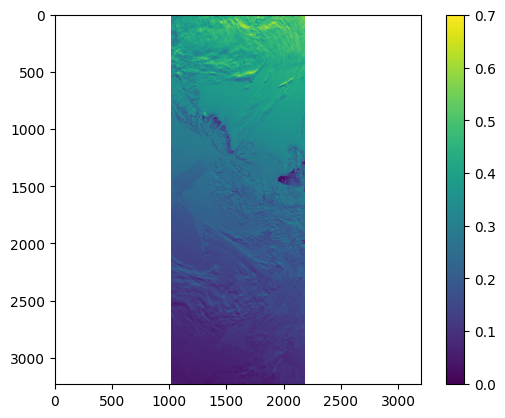

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 nan]


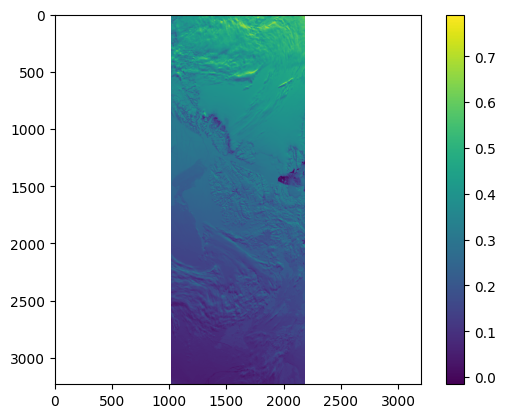

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 nan]


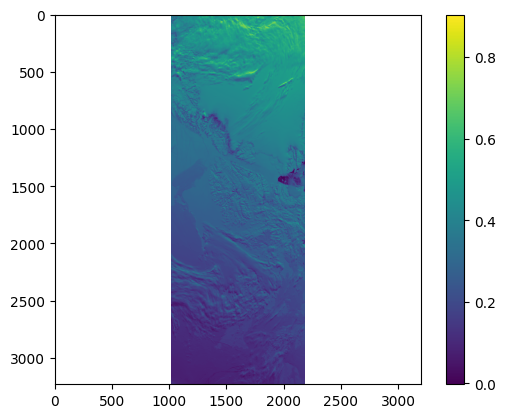

In [ ]:
# Test: plot surface reflectance per band
A04_surf = calculate_surface_albedo(M04_reflectance, a1, b1)
print(np.unique(np.around(A04_surf,decimals=1)))
plt.imshow(A04_surf)
cbar = plt.colorbar()
plt.show()

A05_surf = calculate_surface_albedo(M05_reflectance, a1, b1)
print(np.unique(np.around(A05_surf,decimals=1)))
plt.imshow(A05_surf)
cbar = plt.colorbar()
plt.show()

A07_surf = calculate_surface_albedo(M07_reflectance, a2, b2)
print(np.unique(np.around(A07_surf,decimals=1)))
plt.imshow(A07_surf)
cbar = plt.colorbar()
plt.show()

0.25316455696202533 0.25316455696202533 0.4936708860759494


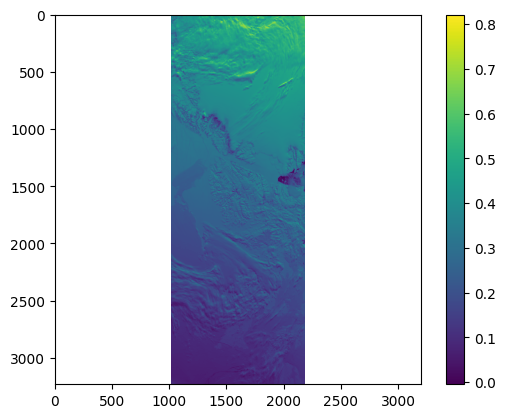

In [ ]:
# Calculate and plot total surface reflectance
M04_bandwidth = 0.020
M05_bandwidth = 0.020
M07_bandwidth = 0.039

M04_weight = M04_bandwidth/(M04_bandwidth+M05_bandwidth+M07_bandwidth)
M05_weight = M05_bandwidth/(M04_bandwidth+M05_bandwidth+M07_bandwidth)
M07_weight = M07_bandwidth/(M04_bandwidth+M05_bandwidth+M07_bandwidth)
print(M04_weight,M05_weight,M07_weight)

# Total surface reflectance is a weighted average based on band width
A_total = (A04_surf*M04_weight) + (A05_surf*M05_weight) + (A07_surf*M07_weight)

plt.imshow(A_total)
cbar = plt.colorbar()
plt.show()

In [ ]:
def crop_array(data):
  bounds = np.where(~np.isnan(data))
  row_min = bounds[0][0]
  row_max = bounds[0][-1]
  col_min = bounds[-1][0]
  col_max = bounds[-1][-1]
  print(row_min,row_max,col_min,col_max)
  return data[0:3231, 1008:2191]

# Crop to remove the scene's fill borders
cropped_A04 = crop_array(A04_surf)
cropped_A05 = crop_array(A05_surf)
cropped_A07 = crop_array(A07_surf)
cropped_A_total = crop_array(A_total)

0 3231 1008 2191
0 3231 1008 2191
0 3231 1008 2191
0 3231 1008 2191


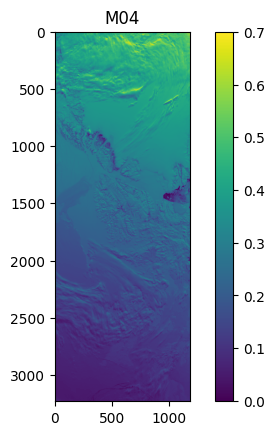

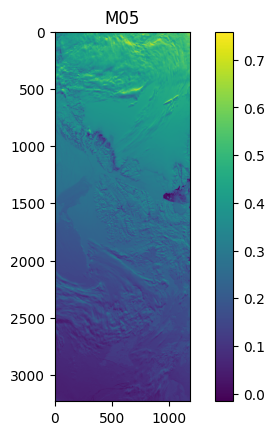

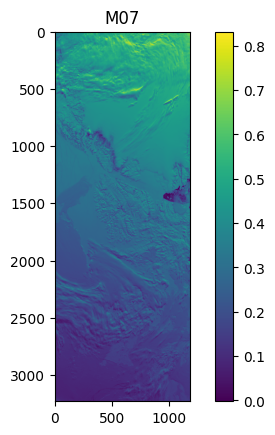

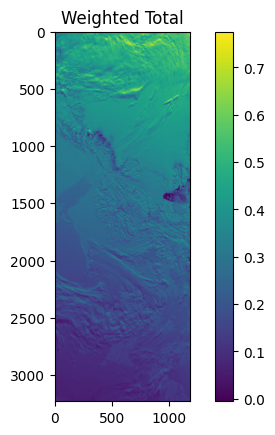

In [ ]:
# Plot and inspect cropped scene
plt.imshow(cropped_A04)
cbar = plt.colorbar()
plt.title("M04")
plt.show()

plt.imshow(cropped_A05)
cbar = plt.colorbar()
plt.title("M05")
plt.show()

plt.imshow(cropped_A07)
cbar = plt.colorbar()
plt.title("M07")
plt.show()

plt.imshow(cropped_A_total)
cbar = plt.colorbar()
plt.title("Weighted Total")
plt.show()

In [ ]:
# Retrieve and inspect land mask
land_mask = np.array(nav_data.groups['geolocation_data'].variables['land_water_mask'])
land_mask

array([[6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       ...,
       [6, 6, 6, ..., 1, 1, 1],
       [6, 6, 6, ..., 1, 1, 1],
       [6, 6, 6, ..., 1, 3, 1]], dtype=uint8)

In [ ]:
# Function to apply the land mask
def set_mask(data,  mask):
  data [np.where((mask == 1))] = np.nan
  return data

0 3231 1008 2191


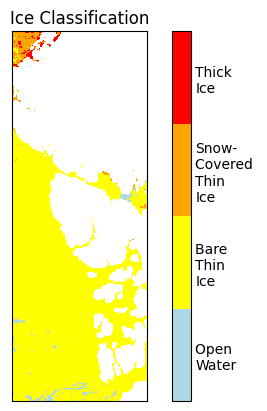

In [ ]:
# Assign classes to the surface albedo data based on Kern et al. 2022 thresholds
ice_water = np.full((x,y), np.nan)
ice_water[np.where((~np.isnan(A_total)) & (A_total > 0.45))] = 3 # thick ice
ice_water[np.where((~np.isnan(A_total)) & (A_total> 0.33) & (A_total <= 0.45))] = 2 # snow-covered thin ice
ice_water[np.where((~np.isnan(A_total)) & (A_total > 0.06) & (A_total <= 0.33))] = 1 # bare thin ice
ice_water[np.where((~np.isnan(A_total)) & (A_total <= 0.06))] = 0 # open water
ice_water = set_mask(ice_water.flatten(),land_mask.flatten()).reshape(x,y)
cropped_ice_water = crop_array(ice_water)

# Plot and inspect scene
fig, ax = plt.subplots()
colors = ['lightblue', 'yellow', 'orange', 'red']
cmap = ListedColormap(colors)
cax = ax.imshow(cropped_ice_water, cmap = cmap)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cbar = plt.colorbar(cax)
cbar.ax.set_yticks([3/8,1.125,1.875,2.625])
cbar.ax.set_yticklabels(['Open \nWater', 'Bare \nThin \nIce', 'Snow-\nCovered \nThin \nIce', 'Thick \nIce'])
cbar.ax.axes.tick_params(length=0)
plt.title("Ice Classification")
plt.show()

In [ ]:
# Calculate SIC using the 12.5 km footprint of a passive microwave sensor
def SIC(data,shape):
  is_ice = ((~np.isnan(data)) & (data > 0))
  SIC = np.round(np.sum(is_ice)/(shape[0]*shape[1]), 1)
  np.put(data, np.where(~np.isnan(data)), SIC)
  return data.reshape(shape)

def get_d_by_d_sections(arr, d):
    m, n = arr.shape
    SIC_grid = np.full((m,n), np.nan)

    # Loop through rows and columns with a step of d
    for i in range(0, m, d):
        for j in range(0, n, d):
            # Define the section boundaries, taking care not to exceed array limits
            end_row = min(i + d, m)
            end_col = min(j + d, n)
            section = arr[i:end_row, j:end_col]
            SIC_section = SIC(section.flatten(), section.shape)
            SIC_grid[i:end_row, j:end_col] = SIC_section

    return SIC_grid

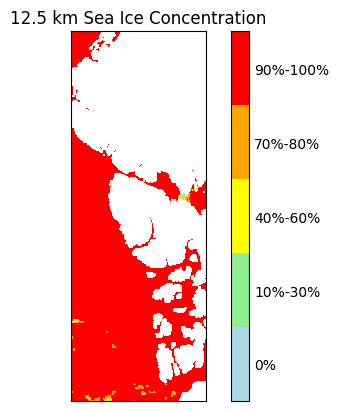

In [ ]:
# Estimate SIC and plot
SIC_plot = get_d_by_d_sections(cropped_ice_water, 17)

map = [0, 0.3, 0.6, 0.8, 1.0]

ice_chart_colours = SIC_plot
ice_chart_colours[np.where((ice_chart_colours == 0.1) | (ice_chart_colours == 0.2))] = 0.3
ice_chart_colours[np.where((ice_chart_colours == 0.4) | (ice_chart_colours == 0.5))] = 0.6
ice_chart_colours[np.where((ice_chart_colours == 0.7))] = 0.8
ice_chart_colours[np.where((ice_chart_colours == 0.9))] = 1.0

labels = ['0%', '10%-30%', '40%-60%','70%-80%','90%-100%']

colours = ['lightblue','lightgreen', 'yellow','orange','red']
cmap = ListedColormap(colours)
fig, ax = plt.subplots()
cax = ax.imshow(ice_chart_colours, cmap=cmap)

cbar = plt.colorbar(cax)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cbar.ax.set_yticks([0.1,0.3,0.5,0.7,0.9])
cbar.ax.set_yticklabels(labels)
cbar.ax.axes.tick_params(length=0)
plt.title("12.5 km Sea Ice Concentration")
plt.show()

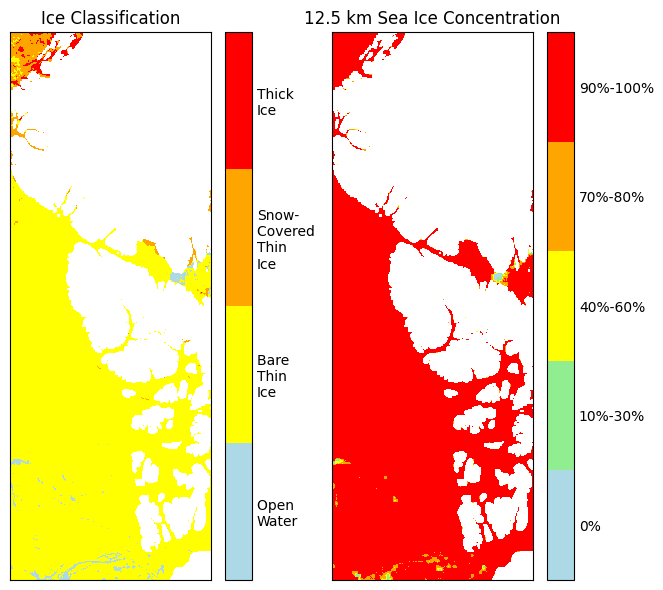

In [ ]:
# Figure and axes setup for combined plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 6))
fig.patch.set_alpha(0)
# Figure 1
colors1 = ['lightblue', 'yellow', 'orange', 'red']
cmap1 = ListedColormap(colors1)
cax1 = ax1.imshow(cropped_ice_water, cmap=cmap1)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
cbar1 = fig.colorbar(cax1, ax=ax1)
cbar1.ax.set_yticks([3/8, 1.125, 1.875, 2.625])
cbar1.ax.set_yticklabels(['Open \nWater', 'Bare \nThin \nIce', 'Snow-\nCovered \nThin \nIce', 'Thick \nIce'])
cbar1.ax.tick_params(length=0)
ax1.set_title("Ice Classification")

# Figure 2
colors2 = ['lightblue', 'lightgreen', 'yellow', 'orange', 'red']
cmap2 = ListedColormap(colors2)
cax2 = ax2.imshow(ice_chart_colours, cmap=cmap2)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
cbar2 = fig.colorbar(cax2, ax=ax2)
cbar2.ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9])
cbar2.ax.set_yticklabels(['0%', '10%-30%', '40%-60%', '70%-80%', '90%-100%'])
cbar2.ax.tick_params(length=0)
ax2.set_title("12.5 km Sea Ice Concentration")

# Adjust layout for tight fit
plt.tight_layout()
plt.savefig('/content/SIC_chart.png', dpi = 330)
plt.show()
